In [1]:
import snowflake
from snowflake.snowpark import Session
# Snowpark for Python
from snowflake.snowpark.types import DoubleType
import snowflake.snowpark.functions as F


import os
from dotenv import load_dotenv

In [10]:
# Snowpark for Python
import snowflake.snowpark.functions as F
from snowflake.snowpark.types import DecimalType

# Snowpark ML
import snowflake.ml.modeling.preprocessing as snowml
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation

# Data Science Libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import json
import joblib

# warning suppresion
import warnings; warnings.simplefilter('ignore')

In [2]:
# Load environment variables from .env file
load_dotenv()
account = os.getenv('ACCOUNT')
password =os.getenv('PASSWORD')
user = os.getenv('USER')
warehouse = os.getenv('WAREHOUSE')
database = os.getenv('DATABASE')
schema = os.getenv('SCHEMA')

In [4]:
CONNECTION_PARAMETERS = {
    "account": account,
    "user": user,
    "password":password,
    # "role": "test_role",
    "database": database,
    "warehouse": warehouse,
    "schema": schema
}

In [5]:
session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [7]:
# Add a query tag to the session.
session.query_tag = {"origin":"sf_sit-is", 
                     "name":"e2e_ml_snowparkpython", 
                     "version":{"major":1, "minor":0,},
                     "attributes":{"is_quickstart":1}}
session

In [8]:
# Data Loading

diamonds_df = session.table('DIAMONDS')
diamonds_df.show()

----------------------------------------------------------------------------------------------------
|"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |
----------------------------------------------------------------------------------------------------
|E        |SI2        |326      |IDEAL      |0.23     |3.95  |3.98  |2.43  |61.5     |55.0         |
|E        |SI1        |326      |PREMIUM    |0.21     |3.89  |3.84  |2.31  |59.8     |61.0         |
|E        |VS1        |327      |GOOD       |0.23     |4.05  |4.07  |2.31  |56.9     |65.0         |
|I        |VS2        |334      |PREMIUM    |0.29     |4.2   |4.23  |2.63  |62.4     |58.0         |
|J        |SI2        |335      |GOOD       |0.31     |4.34  |4.35  |2.75  |63.3     |58.0         |
|J        |VVS2       |336      |VERY_GOOD  |0.24     |3.94  |3.96  |2.48  |62.8     |57.0         |
|I        |VVS1       |336      |VERY_GOOD  |0.24     |3.95  |3.98  |2.47  |62.3     |57.0 

In [11]:
# Normalize the CARAT column
snowml_mms = snowml.MinMaxScaler(input_cols=["CARAT"], output_cols=["CARAT_NORM"])
normalized_diamonds_df = snowml_mms.fit(diamonds_df).transform(diamonds_df)

# Reduce the number of decimals
new_col = normalized_diamonds_df.col("CARAT_NORM").cast(DecimalType(7, 6))
normalized_diamonds_df = normalized_diamonds_df.with_column("CARAT_NORM", new_col)

normalized_diamonds_df

In [12]:
normalized_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------
|"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |"CARAT_NORM"  |
-------------------------------------------------------------------------------------------------------------------
|E        |SI2        |326      |IDEAL      |0.23     |3.95  |3.98  |2.43  |61.5     |55.0         |0.006237      |
|E        |SI1        |326      |PREMIUM    |0.21     |3.89  |3.84  |2.31  |59.8     |61.0         |0.002079      |
|E        |VS1        |327      |GOOD       |0.23     |4.05  |4.07  |2.31  |56.9     |65.0         |0.006237      |
|I        |VS2        |334      |PREMIUM    |0.29     |4.2   |4.23  |2.63  |62.4     |58.0         |0.018711      |
|J        |SI2        |335      |GOOD       |0.31     |4.34  |4.35  |2.75  |63.3     |58.0         |0.022869      |
|J        |VVS2       |336      |VERY_GOOD  |0.24     |3.94  |3.96  |2.4

In [13]:
# Encode CUT and CLARITY preserve ordinal importance
categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
}
snowml_oe = snowml.OrdinalEncoder(input_cols=["CUT", "CLARITY"], output_cols=["CUT_OE", "CLARITY_OE"], categories=categories)
ord_encoded_diamonds_df = snowml_oe.fit(normalized_diamonds_df).transform(normalized_diamonds_df)

# Show the encoding
print(snowml_oe._state_pandas)

ord_encoded_diamonds_df.show()

   _COLUMN_NAME  _CATEGORY  _INDEX
0           CUT      IDEAL       0
1           CUT    PREMIUM       1
2           CUT  VERY_GOOD       2
3           CUT       GOOD       3
4           CUT       FAIR       4
5       CLARITY         IF       0
6       CLARITY       VVS1       1
7       CLARITY       VVS2       2
8       CLARITY        VS1       3
9       CLARITY        VS2       4
10      CLARITY        SI1       5
11      CLARITY        SI2       6
12      CLARITY         I1       7
13      CLARITY         I2       8
14      CLARITY         I3       9
---------------------------------------------------------------------------------------------------------------------------------------------
|"CUT_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |"CARAT_NORM"  |
---------------------------------------------------------------------------------------------------------------------------------------------
|0.0       |6.

In [14]:
# Encode categoricals to numeric columns
snowml_ohe = snowml.OneHotEncoder(input_cols=["CUT", "COLOR", "CLARITY"], output_cols=["CUT_OHE", "COLOR_OHE", "CLARITY_OHE"])
transformed_diamonds_df = snowml_ohe.fit(ord_encoded_diamonds_df).transform(ord_encoded_diamonds_df)

np.array(transformed_diamonds_df.columns)

array(['CUT_OHE_FAIR', 'CUT_OHE_GOOD', 'CUT_OHE_IDEAL', 'CUT_OHE_PREMIUM',
       'CUT_OHE_VERY_GOOD', 'COLOR_OHE_D', 'COLOR_OHE_E', 'COLOR_OHE_F',
       'COLOR_OHE_G', 'COLOR_OHE_H', 'COLOR_OHE_I', 'COLOR_OHE_J',
       'CLARITY_OHE_I1', 'CLARITY_OHE_IF', 'CLARITY_OHE_SI1',
       'CLARITY_OHE_SI2', 'CLARITY_OHE_VS1', 'CLARITY_OHE_VS2',
       'CLARITY_OHE_VVS1', 'CLARITY_OHE_VVS2', 'CUT_OE', 'CLARITY_OE',
       'COLOR', 'CLARITY', 'PRICE', 'CUT', 'CARAT', 'X', 'Y', 'Z',
       'DEPTH', 'TABLE_PCT', 'CARAT_NORM'], dtype='<U17')

In [15]:
transformed_diamonds_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUT_OHE_FAIR"  |"CUT_OHE_GOOD"  |"CUT_OHE_IDEAL"  |"CUT_OHE_PREMIUM"  |"CUT_OHE_VERY_GOOD"  |"COLOR_OHE_D"  |"COLOR_OHE_E"  |"COLOR_OHE_F"  |"COLOR_OHE_G"  |"COLOR_OHE_H"  |"COLOR_OHE_I"  |"COLOR_OHE_J"  |"CLARITY_OHE_I1"  |"CLARITY_OHE_IF"  |"CLARITY_OHE_SI1"  |"CLARITY_OHE_SI2"  |"CLARITY_OHE_VS1"  |"CLARITY_OHE_VS2"  |"CLARITY_OHE_VVS1"  |"CLARITY_OHE_VVS2"  |"CUT_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |"CARAT"  |"X"   |"Y"   |"Z"   |"DEPTH"  |"TABLE_PCT"  |

In [16]:
# Categorize all the features for processing
CATEGORICAL_COLUMNS = ["CUT", "COLOR", "CLARITY"]
CATEGORICAL_COLUMNS_OE = ["CUT_OE", "COLOR_OE", "CLARITY_OE"] # To name the ordinal encoded columns
NUMERICAL_COLUMNS = ["CARAT", "DEPTH", "TABLE_PCT", "X", "Y", "Z"]

categories = {
    "CUT": np.array(["IDEAL", "PREMIUM", "VERY_GOOD", "GOOD", "FAIR"]),
    "CLARITY": np.array(["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1", "I2", "I3"]),
    "COLOR": np.array(['D', 'E', 'F', 'G', 'H', 'I', 'J']),
}

In [21]:
# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
            (
                "OE",
                snowml.OrdinalEncoder(
                    input_cols=CATEGORICAL_COLUMNS,
                    output_cols=CATEGORICAL_COLUMNS_OE,
                    categories=categories,
                )
            ),
            (
                "MMS",
                snowml.MinMaxScaler(
                    clip=True,
                    input_cols=NUMERICAL_COLUMNS,
                    output_cols=NUMERICAL_COLUMNS,
                )
            )
    ]
)

PIPELINE_FILE = r'D:\Prakash\Github\Snowflake-Practice\machine_learning\tmp\preprocessing_pipeline.joblib'
joblib.dump(preprocessing_pipeline, PIPELINE_FILE) # We are just pickling it locally first

transformed_diamonds_df = preprocessing_pipeline.fit(diamonds_df).transform(diamonds_df)
transformed_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.006237006237006237  |0.5138888888888888   |0.23076923076923073  |0.3677839851024209   |0.06757215619694397  |0.07641509433962265  |0.0       |1.0         |6.0           |E        |SI2        |326      |IDEAL      |
|0.002079002079002079  |0.46666666666666656  |0.34615384615384615  |0.36219739292364994  |0.06519524617996604  |0.07264150943396

In [22]:
# You can also save the pickled object into the stage we created earlier for deployment
session.file.put(PIPELINE_FILE, "@ML_ASSETS", overwrite=True)

SnowparkSQLException: (1304): 01b70036-3201-3669-000a-1e7a0001fc5e: 002003 (02000): SQL compilation error:
Stage 'ML_DB.ANALYSIS.ML_ASSETS' does not exist or not authorized.

In [23]:
connections = snowflake.connector.connect(user = user,
                                  password = password,
                                  account = account,
                                  database = database,
                                  schema = schema)

cursor = connections.cursor()

In [24]:
cursor.execute('show stages;')
cursor.fetchall()

[(datetime.datetime(2024, 9, 11, 22, 36, 52, 661000, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>),
  'DIAMONDS_ASSETS',
  'ML_DB',
  'ANALYSIS',
  's3://sfquickstarts/intro-to-machine-learning-with-snowpark-ml-for-python/diamonds.csv',
  'N',
  'N',
  'ACCOUNTADMIN',
  '',
  'us-west-1',
  'EXTERNAL',
  'AWS',
  None,
  None,
  None,
  'ROLE',
  'N')]

In [26]:
cursor.execute('CREATE STAGE ML_ASSETS;')
cursor.execute('show stages;')
cursor.fetchall()

[(datetime.datetime(2024, 9, 11, 22, 36, 52, 661000, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>),
  'DIAMONDS_ASSETS',
  'ML_DB',
  'ANALYSIS',
  's3://sfquickstarts/intro-to-machine-learning-with-snowpark-ml-for-python/diamonds.csv',
  'N',
  'N',
  'ACCOUNTADMIN',
  '',
  'us-west-1',
  'EXTERNAL',
  'AWS',
  None,
  None,
  None,
  'ROLE',
  'N'),
 (datetime.datetime(2024, 9, 13, 3, 13, 22, 773000, tzinfo=<DstTzInfo 'America/Los_Angeles' PDT-1 day, 17:00:00 DST>),
  'ML_ASSETS',
  'ML_DB',
  'ANALYSIS',
  '',
  'N',
  'N',
  'ACCOUNTADMIN',
  '',
  None,
  'INTERNAL',
  None,
  None,
  None,
  None,
  'ROLE',
  'N')]

In [27]:
# You can also save the pickled object into the stage we created earlier for deployment
session.file.put(PIPELINE_FILE, "@ML_ASSETS", overwrite=True)

[PutResult(source='preprocessing_pipeline.joblib', target='preprocessing_pipeline.joblib.gz', source_size=2104, target_size=1152, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]


# EDA

In [33]:
transformed_diamonds_df.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CARAT"               |"DEPTH"              |"TABLE_PCT"          |"X"                  |"Y"                  |"Z"                  |"CUT_OE"  |"COLOR_OE"  |"CLARITY_OE"  |"COLOR"  |"CLARITY"  |"PRICE"  |"CUT"      |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0.006237006237006237  |0.5138888888888888   |0.23076923076923073  |0.3677839851024209   |0.06757215619694397  |0.07641509433962265  |0.0       |1.0         |6.0           |E        |SI2        |326      |IDEAL      |
|0.002079002079002079  |0.46666666666666656  |0.34615384615384615  |0.36219739292364994  |0.06519524617996604  |0.07264150943396

In [31]:
corr_df = correlation(df = transformed_diamonds_df)
corr_df

Got error object of type 'NoneType' has no len() when trying to read default values from function: <class 'snowflake.ml.modeling.metrics.metrics_utils.register_sharded_dot_sum_computer.<locals>.ShardedDotAndSumComputer'>. Proceeding without creating optional arguments
Got error object of type 'NoneType' has no len() when trying to read default values from function: <class 'snowflake.ml.modeling.metrics.metrics_utils.register_accumulator_udtf.<locals>.Accumulator'>. Proceeding without creating optional arguments


,CARAT,DEPTH,TABLE_PCT,X,Y,Z,CUT_OE,COLOR_OE,CLARITY_OE,PRICE
CARAT,1.000000,0.028224,0.181618,0.975094,0.951722,0.953387,0.134967,0.291437,0.352841,0.921591
DEPTH,0.028224,1.000000,-0.295779,-0.025289,-0.029341,0.094924,0.218055,0.047279,0.067384,-0.010647
TABLE_PCT,0.181618,-0.295779,1.000000,0.195344,0.183760,0.150929,0.433405,0.026465,0.160327,0.127134
X,0.975094,-0.025289,0.195344,1.000000,0.974701,0.970772,0.125565,0.270287,0.371999,0.884435
Y,0.951722,-0.029341,0.183760,0.974701,1.000000,0.952006,0.121462,0.263584,0.358420,0.865421
Z,0.953387,0.094924,0.150929,0.970772,0.952006,1.000000,0.149323,0.268227,0.366952,0.861249
CUT_OE,0.134967,0.218055,0.433405,0.125565,0.121462,0.149323,1.000000,0.020519,0.189175,0.053491
COLOR_OE,0.291437,0.047279,0.026465,0.270287,0.263584,0.268227,0.020519,1.000000,-0.025631,0.172511
CLARITY_OE,0.352841,0.067384,0.160327,0.371999,0.358420,0.366952,0.189175,-0.025631,1.000000,0.146800
PRICE,0.921591,-0.010647,0.127134,0.884435,0.865421,0.861249,0.053491,0.172511,0.146800,1.000000


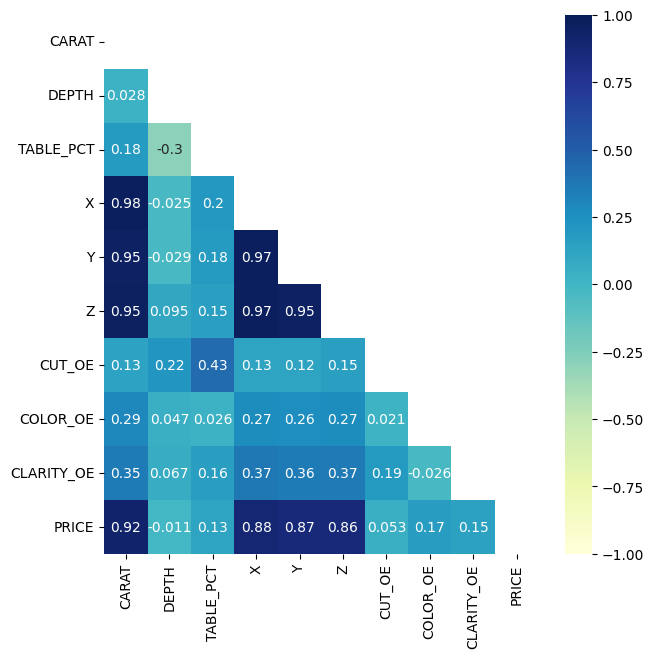

In [34]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Create a heatmap with the features
plt.figure(figsize=(7, 7))
heatmap = sns.heatmap(corr_df, mask=mask, cmap="YlGnBu", annot=True, vmin=-1, vmax=1)

<Axes: >

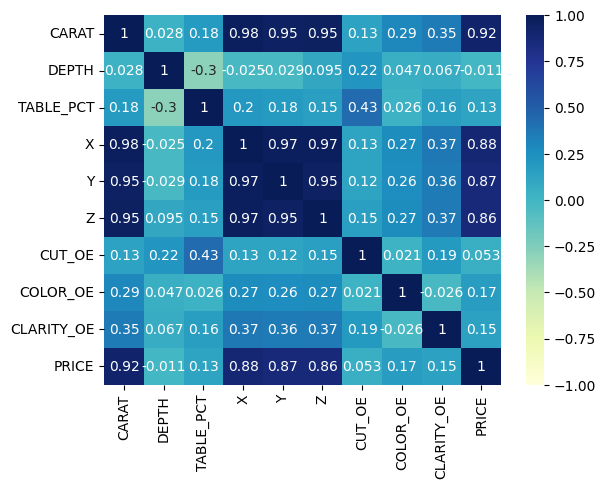

In [35]:
sns.heatmap(corr_df, cmap="YlGnBu", annot=True, vmin=-1, vmax=1)

We note that CARAT and PRICE are highly correlated, which makes sense! Let's take a look at their relationship a bit closer.

Note: You will have to convert your Snowpark DF to a Pandas DF in order to use matplotlib & seaborn.

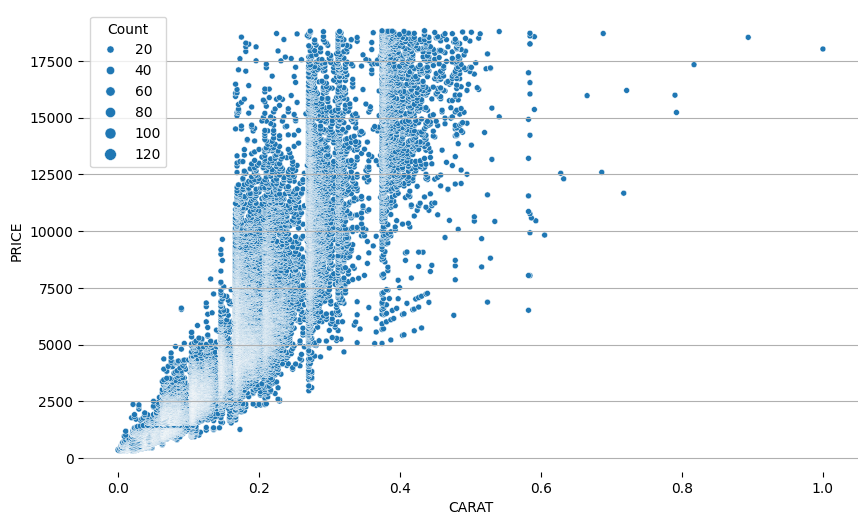

In [36]:
# Set up a plot to look at CARAT and PRICE
counts = transformed_diamonds_df.to_pandas().groupby(['PRICE', 'CARAT']).size().reset_index(name='Count')

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.scatterplot(data=counts, x='CARAT', y='PRICE', size='Count', markers='o', alpha=1)
ax.grid(axis='y')

# The relationship is not linear - it appears exponential which makes sense given the rarity of the large diamonds
sns.move_legend(ax, "upper left")
sns.despine(left=True, bottom=True)

In [39]:
session.close()
connections.close()
cursor.close()

False